In [1]:
import pandas as pd
# import datetime as dt

## Cargar Indices de precios

In [2]:
#### USANDO DATA ONLINE (INFRA DATOS, i.e. portal oficial de Datos Argentina)

link_CBA = 'https://infra.datos.gob.ar/catalog/sspm/dataset/445/distribution/445.1/download/canasta-basica-alimentaria-regiones-del-pais.csv'
CBAr = pd.read_csv(link_CBA)
CBAr.index = pd.to_datetime(CBAr.indice_tiempo); CBAr = CBAr.drop('indice_tiempo', axis = 1)

link_CBT = 'https://infra.datos.gob.ar/catalog/sspm/dataset/446/distribution/446.1/download/canasta-basica-total-regiones-del-pais.csv'
CBTr = pd.read_csv(link_CBT)
CBTr.index = pd.to_datetime(CBTr.indice_tiempo); CBTr = CBTr.drop('indice_tiempo', axis = 1)

CB = pd.concat([CBAr.stack(), CBTr.stack()], axis = 1)
CB.columns = ['CBA', 'CBT']; CB.index.names = ['Mes', 'Region']
## Atenti que los nombres de regiones difieren (estan en lowercase y con '_')

In [3]:
ultimo_mes = CB.index.get_level_values('Mes').max()
ultimo_mes

Timestamp('2021-12-01 00:00:00')

In [4]:
cpi_M = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/IPC-Argentina/main/data/info/indice_precios_M.csv', index_col=0)
cpi_M.index = pd.to_datetime(cpi_M.index)

## OPCION INDICE SE FIJA X MES
ref = '2016-01'
cpi_ref = cpi_M.loc[ref]['index'][0] ## OJO porque los modelos vienen entrenados con sueldos de esa nominalidad.

# O sea, la fecha de escala nominal de aca (canasta) tiene que ser la misma que la de los modelos (EPH training).

cpi_M_CB = cpi_M.loc[CB.unstack().index]
cpi_M_CB.columns = pd.MultiIndex.from_product([['Indice de Precios'], cpi_M_CB.columns])


In [5]:
## Concatenar indice de precios a los valores nominales
CB_i = pd.concat([CB.unstack(), cpi_M_CB], axis = 1)

## Dividir por IPC y multiplicar por indice en punto de referencia.
CB_defl = CB_i.drop('Indice de Precios', axis = 1).div(
    CB_i[('Indice de Precios', 'index')], 0)*cpi_ref

CB_defl = CB_defl.reindex(cpi_M.loc['2003':].index)


## Comparacion canasta Basica vs Total

In [6]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

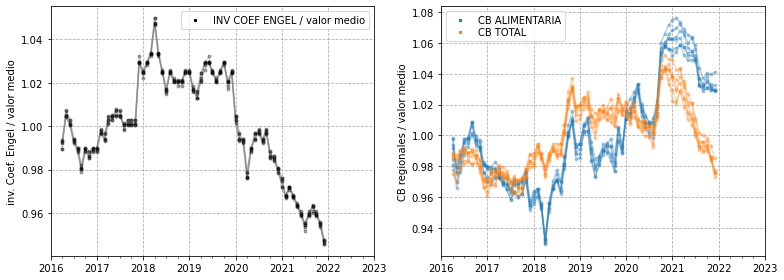

In [20]:
data = CB_defl.dropna()

fig, axs = plt.subplots(1, 2, figsize = (11, 4))

ax = axs[1]
(data/data.mean()).plot(legend = False, marker = '.', color = 6*['#1f77b4']+6*['#ff7f0e'], alpha = .3, ax = ax)

pts1 = mlines.Line2D([], [], lw = 0, marker = 's', c = '#1f77b4', markersize = 2, label = 'CB ALIMENTARIA')
pts2 = mlines.Line2D([], [], lw = 0, marker = 's', c = '#ff7f0e', markersize = 2, label = 'CB TOTAL')
ax.legend(handles=[pts1, pts2], numpoints = 1, labelspacing = .2)
ax.set_ylabel('CB regionales / valor medio')

ax = axs[0]
engel = (data['CBT']/data['CBA'])
(engel/engel.mean()).plot(legend = False, alpha = .3, ax = ax, color = '.5')
(engel/engel.mean()).plot(legend = False, marker = '.', alpha = .3, ax = ax, color = 'k', lw = 0)

pts1 = mlines.Line2D([], [], lw = 0, marker = 's', c = 'k', markersize = 2, label = 'INV COEF ENGEL / valor medio')
# pts2 = mlines.Line2D([], [], lw = 0, marker = 's', c = '#ff7f0e', markersize = 2, label = 'CB TOTAL')
ax.legend(handles=[pts1], numpoints = 1, labelspacing = .2)

ax.set_ylabel('inv. Coef. Engel / valor medio')

for ax in axs:
    ax.grid(linestyle = '--')
    ax.set_xlim('2016', '2023')
    
plt.tight_layout()
plt.savefig('./CBEng.jpg')
plt.show()

In [14]:
pd.DataFrame(engel.mean().round(2))

,0
Region,
gran_buenos_aires,2.44
cuyo,2.60
noreste,2.28
noroeste,2.26
pampeana,2.44
patagonia,2.77


In [17]:
round(engel.mean().mean(), 3)

2.465

## Frecuencia trimestral, precios de referencia

In [ ]:
## Extension desde 2003, y meses presentes.
CB_defl = CB_defl.fillna(CB_defl.mean())

# Agrupar a frecuEncia cuatrimestral
CB_defl_Q = CB_defl.stack().groupby([pd.Grouper(level = 0,freq = 'Q'), pd.Grouper(level = 1)]).mean()
CB_defl_Q.index.names = ['Q', 'Region']

CB_defl_Q = CB_defl_Q.unstack()
CB_defl_Q.index = CB_defl_Q.index - pd.to_timedelta(CB_defl_Q.index.day - 15, unit='d') - pd.DateOffset(months=1)

CB_defl_Q = CB_defl_Q.stack().reset_index()
CB_defl_Q.to_csv('./data/CB_Reg_defl_Q.csv', index = False)
# # precios de 2016-1-1

## Frecuencia mensual, precios actuales

In [ ]:
from datetime import datetime as dt
  
# Getting current date and time
today = dt.today()
mes_actual = today.strftime("%Y-%m")

cpi_actual = cpi_M.loc[mes_actual]['index'][0]
cpi_ref = cpi_M.loc[ref]['index'][0]
cpi_ult_mes_CB = cpi_M.loc[ultimo_mes]['index']

CB_hoy = CB_defl*(cpi_actual/cpi_ref)
CB_hoy = CB_hoy.round(-1).astype(int)
CB_hoy.index.name = 'Q'

tabla_CB_hoy = CB_hoy.loc[mes_actual].stack()
CB_hoy = CB_hoy.stack().reset_index()
CB_hoy.to_csv('./data/CB_Reg_defl_m.csv', index = False)

In [ ]:
CB.loc['2018-05']

### Canastas de mes seleccionado

In [ ]:
# mostrar_mes = ultimo_mes
mostrar_mes = '2010-11'

cb = CB_defl.loc[mostrar_mes].stack()
tabla = pd.concat([cb*(cpi_M.loc[mostrar_mes]['index'][0]/cpi_ref), 
           cb*(cpi_actual/cpi_ref)], axis = 1).round(-1).astype(int).sort_index()

tabla.columns = pd.MultiIndex.from_product([['AR$ '+mostrar_mes, 'AR$ '+mes_actual], ['CBA', 'CBT']], names=['Nominalidad', 'Canasta'])

tabla

### Canastas del ultimo mes publicado 

In [ ]:
mostrar_mes = ultimo_mes.strftime("%Y-%m")
# mostrar_mes = '2010-11'

cb = CB_defl.loc[mostrar_mes].stack()

tabla = pd.concat([cb*(cpi_M.loc[mostrar_mes]['index'][0]/cpi_ref), 
           cb*(cpi_actual/cpi_ref)], axis = 1).round(-1).astype(int).sort_index()

tabla.columns = pd.MultiIndex.from_product([['AR$ '+mostrar_mes, 'AR$ '+mes_actual], ['CBA', 'CBT']], names=['Nominalidad', 'Canasta'])

tabla

### Mostrar tablita

In [ ]:
import df2img

fig = df2img.plot_dataframe(
    tabla_CB_hoy.T[mes_actual].T,
    title = dict(text='Costos actuales de canastas (AR$ '+mes_actual+')'),
    row_fill_color=("#ffffff", "#d7d8d6"),
    fig_size=(400, 220),
)

df2img.save_dataframe(fig=fig, filename="CB.jpg")

## Frecuencia trimestral, precios de referencia, corrientes y actuales

In [ ]:

cpi_Q = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/IPC-Argentina/main/data/info/indice_precios_Q.csv', index_col=0)
cpi_Q.index = pd.to_datetime(cpi_Q.index)

CB_nom_Q = CB_defl_Q.merge(cpi_Q.reset_index())
CB_nom_Q[['CBA_ARScorr', 'CBT_ARScorr']] = CB_nom_Q[['CBA', 'CBT']].mul(CB_nom_Q['index'] / cpi_ref, 0).round().astype(int)
CB_nom_Q[['CBA_'+mes_actual, 'CBT_'+mes_actual]] = CB_nom_Q[['CBA', 'CBT']].mul(cpi_actual/ cpi_ref, 0).round().astype(int)
CB_nom_Q = CB_nom_Q.rename(columns = {'CBA': 'CBA_'+ref, 'CBT': 'CBT_'+ref})
CB_nom_Q.to_csv('./data/CB_Reg_nom_Q.csv', index = False)